In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import random
import numpy as np
import glob
import string
import matplotlib
import allel
import operator as op
# import matplotlib.gridspec as gridspec

from allel.util import asarray_ndim
from itertools import groupby
from functools import reduce
from collections import Counter
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

random.seed(42)

%matplotlib inline

df_headers = """sample,pop_id,sample_id,clus_start_chrom,clus_start_align,clust_start1,
clust_end1,sp1_qry,sp1_ref,sp2_ref,sp3_ref,sp4_ref,iden_up,ident_rep,
ident_down,ident_inv,ident_fwd,ident_epo,masked,sum_ins,sum_del,sum_mis,
sum_nuc,CpG,clus_ins,clus_del,clus_mis,fwd_score,ts_score,ts_score_maxj,ts_ref_seq_len,
ts_qry_seq_len,f1_len,f2_len,f3_len,LPR,chrom""".strip().replace("\n", "").split(",")

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

grid_grey = "#e0e0e0"
grey = "#BDBDBD"
border_width = 0.5
threshold_line_width = .75
linewidth = 6.202 # linewidth from latex document

pop_colours = {
    'AMR': '#FFB300',
    'AFR': '#E91E63',
    'SAS': '#0D47A1', 
    'EAS': '#2196F3',
    'EUR': '#673AB7',
    'ALL': 'black'
}

ts_green = "#3D8F24"
ts_purple = "#6E38CC"

sns.set_context("paper", rc={"font.size": 8,
                             "axes.labelsize": 8,
                             "xtick.labelsize": 8,
                             "ytick.labelsize": 8,
                             "legend.fontsize": 8,
                             "legend.title_fontsize": 8,
                             "axes.linewidth": border_width}) 

In [48]:
def add_score_diffs(fpa_df):
    fpa_df['fwd_score'] = pd.to_numeric(fpa_df['fwd_score'])
    fpa_df['ts_score'] = pd.to_numeric(fpa_df['ts_score'])
    fpa_df['score_diff'] = fpa_df['ts_score'] - fpa_df['fwd_score']
    fpa_df['score_D'] = fpa_df['ts_score_maxj'] - fpa_df['fwd_score']
    fpa_df['sp2_ref'] = pd.to_numeric(fpa_df['sp2_ref'])
    fpa_df['sp3_ref'] = pd.to_numeric(fpa_df['sp3_ref'])
    fpa_df['ident_ratio'] = fpa_df["ident_fwd"] / fpa_df["ident_inv"] 
    fpa_df['length'] = fpa_df['sp2_ref'] - fpa_df['sp3_ref'] + 1
    return fpa_df


def read_csvs_from_dir(csv_path, head_names):
    if csv_path[-1] == "/":
        file_list = glob.glob(csv_path + "*.csv")
    else:
        file_list = glob.glob(csv_path + "/*.csv")
    csv_list = []
    for f in file_list:
        df = pd.read_csv(f, index_col=None, header=None,
                         low_memory=False, names=head_names)
        csv_list.append(df)
    return pd.concat(csv_list, axis=0, ignore_index=True)


def sample_line_counts(file_list):
    count_list = []
    for f in file_list:
        with open(f, "r") as read_f:
            count_list.append(len(read_f.readlines()))
    return count_list


def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=" ", color=pop_colours[pop],
                label=pop, markersize=6, mec='k', mew=0, alpha=.8)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))
    

def fig_pca(coords, model, sample_population=None):
    if sample_population is None:
        sample_population = df_samples["Superpopulation"].values
    # plot coords for PCs 1 vs 2, 3 vs 4
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(1, 2, 1)
    plot_pca_coords(coords, model, 0, 1, ax, sample_population)
    ax = fig.add_subplot(1, 2, 2)
    plot_pca_coords(coords, model, 2, 3, ax, sample_population)
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #ax.fontsize(20)
    #fig.suptitle(title, y=1.02)
    fig.tight_layout()


def ld_prune(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn,
                                             size=size,
                                             step=step,
                                             threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn


def plot_pca_coords(coords, model, pc1, pc2, ax, sample_population):
    #sns.despine(ax=ax, offset=5)
    x = coords[:, pc1]
    y = coords[:, pc2]
    for pop in populations:
        flt = (sample_population == pop)
        ax.plot(x[flt], y[flt], marker='o', linestyle=" ", color=pop_colours[pop],
                label=pop, markersize=3.5, mec='k', mew=0, alpha=.8)
    ax.set_xlabel('PC%s (%.1f%%)' % (pc1+1, model.explained_variance_ratio_[pc1]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (pc2+1, model.explained_variance_ratio_[pc2]*100))


def plot_variant_hist(callset, f, bins=30):
    x = callset[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)


def read_csvs_from_list(file_list, head_names):
    csv_list = []
    for f in file_list:
        df = pd.read_csv(f, index_col=None, header=None,
                         low_memory=False, names=head_names)
        csv_list.append(df)
    return pd.concat(csv_list, axis=0, ignore_index=True)


def plot_sfs(s, yscale='log', bins=None, n=None,
             clip_endpoints=True, label=None, plot_kwargs=None,
             ax=None, line_color=None, linew=2):
    # check inputs
    s = asarray_ndim(s, 1)

    # setup axes
    if ax is None:
        fig, ax = plt.subplots()

    # setup data
    if bins is None:
        if clip_endpoints:
            x = np.arange(1, s.shape[0]-1)
            y = s[1:-1]
        else:
            x = np.arange(s.shape[0])
            y = s
    else:
        if clip_endpoints:
            y, b, _ = scipy.stats.binned_statistic(
                np.arange(1, s.shape[0]-1),
                values=s[1:-1],
                bins=bins,
                statistic='sum')
        else:
            y, b, _ = scipy.stats.binned_statistic(
                np.arange(s.shape[0]),
                values=s,
                bins=bins,
                statistic='sum')
        # use bin midpoints for plotting
        x = (b[:-1] + b[1:]) / 2

    if n:
        # convert allele counts to allele frequencies
        x = x / n
        ax.set_xlabel('derived allele frequency')
    else:
        ax.set_xlabel('derived allele count')

    # do plotting
    if plot_kwargs is None:
        plot_kwargs = dict()
    if line_color:
        plt.plot(x, y, label=label, **plot_kwargs, color=line_color)
    else:
        plt.plot(x, y, label=label, **plot_kwargs, linewidth=linew)
    return ax


def plot_sfs_folded(*args, **kwargs):
    ax = plot_sfs(*args, **kwargs)
    n = kwargs.get('n', None)
    if n:
        ax.set_xlabel('minor allele frequency')
    else:
        ax.set_xlabel('minor allele count')
    return ax


def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()
    ax.bar(left, pc) #, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    handles = [mpl.patches.Patch(color=palette[0]),
               mpl.patches.Patch(color=palette[1])]


def style_grid(ax,
               a_offset=-0.175,
               b_offset=-0.175,
               x_grid=True,
               y_grid=True):
    x_offset = [a_offset, b_offset]
    label_subplots = True
    try:
        len(ax)
    except:
        ax = [ax]
        label_subplots = False
    for n, a in enumerate(ax):
        if label_subplots:
            a.text(x_offset[n], 1.01, string.ascii_lowercase[n], transform=a.transAxes, 
                    size=12, weight='bold')
        a.tick_params(axis='y', which='major', pad=2)

    for a in (ax):
        if x_grid:
            a.xaxis.grid(color="#e0e0e0",
                        linewidth=border_width)
        if y_grid:
            a.yaxis.grid(color="#e0e0e0",
                        linewidth=border_width)

    for a in ax:
        a.tick_params(bottom=True, left=True,
                    axis="both",
                    length=3,
                    which="major",
                    width=border_width)


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes,
                      color='black',
                      linewidth=.5)
    line.set_clip_on(False)
    ax.add_line(line)


def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            if label in ["AFR", "AMR", "SAS", "EAS", "EUR"]:
                ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            else:
                ax.text(lxpos, ypos, label, ha='center', rotation=90, transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom


def count_snps_indels_per_event(variant_dic):
    """
    Take in a dictionary where keys are unique event IDs and
    values are a list of tuples of form (REF, ALT). Count SNPS and
    indels per event. 
    Return a DF
    """
    counts = {}
    for k, v in variant_dic.items():
        counts[k] = {"SNP": 0, "INS": 0, "DEL": 0}
        for var in v:
            if len(var[0]) == 1 and len(var[1]) == 1:
                counts[k]["SNP"] += 1
            else:
                # deletions
                if len(var[0]) > len(var[1]):
                    counts[k]["DEL"] += len(var[0]) - len(var[1])
                elif len(var[1]) > len(var[0]):
                    counts[k]["INS"] += len(var[1]) - len(var[0])
                else:
                    raise ValueError # dinucleotide subs etc?
    count_df = pd.DataFrame(counts).T
    count_df["indels"] = count_df["INS"] + count_df["DEL"]
    return count_df


def divide_by_total(var_list):
    return [(float(i)/var_list[-1])*100 for i in var_list]

In [4]:
df_samples = pd.read_csv("data/sample_info.tsv",
                             delimiter=" ",
                             index_col=None)
populations = df_samples["Superpopulation"].unique()

all_event_count = pd.read_csv("data/1k_30x_haplotypes/event_counts.tsv",
                              delimiter="\t",
                              header=None,
                              names=["SampleID","all_event_count"])
                              
df_samples = pd.merge(df_samples, all_event_count, on="SampleID")

In [5]:
no_dup_vcf_path = "data/1k_30x_haplotypes/final_ref_ancestral_renamed_one.vcf"

no_dup_22_callset = allel.read_vcf(no_dup_vcf_path)
gt = allel.GenotypeArray(no_dup_22_callset["calldata/GT"])
ac = gt.count_alleles()[:]
n_variants = len(gt)
flt = (ac[:, :2].min(axis=1) > 1) & (ac.max_allele() == 1)
gf = gt.compress(flt, axis=0)

#Finally, transform the genotype data into a 2-dimensional matrix where
# each cell has the number of non-reference alleles per call.
# This is what we’ll use as the input to PCA.
gn = gf.to_n_alt()
gnu = ld_prune(gn, size=50, step=10, threshold=.1, n_iter=1)

iteration 1 retaining 3285 removing 63 variants


In [6]:
pos = no_dup_22_callset['variants/POS']

In [7]:
allel.tajima_d(ac)

-1.3119321495135372

In [8]:
# perform PCA
coords, model = allel.pca(gn, n_components=4, scaler="patterson")

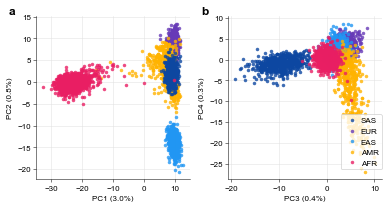

In [9]:
# plot PCs
sample_population = df_samples["Superpopulation"].values
# plot coords for PCs 1 vs 2, 3 vs 4

fig, ax = plt.subplots(1, 2, figsize=(linewidth,round(linewidth/2)))

plot_pca_coords(coords, model, 0, 1, ax[0], sample_population)
plot_pca_coords(coords, model, 2, 3, ax[1], sample_population)

# re-order legend to match subsequent plot
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2,4]
leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                bbox_to_anchor=(1.025, 0.425),
                loc='upper right',
                handletextpad=0.1,
                 )

leg._legend_box.align = "center"

sns.despine()

x_offset = [-0.175,-0.175]

for n, a in enumerate(ax):
    a.text(x_offset[n], 1.01, string.ascii_lowercase[n], transform=a.transAxes, 
            size=12, weight='bold')
    a.tick_params(axis='y', which='major', pad=2)


for a in (ax):
    a.xaxis.grid(color="#e0e0e0",
                 linewidth=border_width)
    a.yaxis.grid(color="#e0e0e0",
                 linewidth=border_width)


for a in ax:
    a.tick_params(bottom=True, left=True,
                  axis="both",
                  length=3,
                  width=border_width)

plt.subplots_adjust(wspace=.25)

# plt.savefig("PCA_testing_14_LDprune_ref_ancestral.pdf",
#              bbox_inches="tight",
#              format="pdf")

In [14]:
# define SFS
# do not look at chrX when looking at patterns of hetero/homozygosity
autosome_unique_path = "data/1k_30x_haplotypes/final_ref_ancestral_renamed_one_autosomes.vcf"
quick_unique_path = "data/1k_30x_haplotypes/all_merged.vcf.gz"
#quick_unique_path = "data/1k_30x_haplotypes/all_merged_no_children.vcf"

sfs_callset = allel.read_vcf(quick_unique_path)
sfs_gt = allel.GenotypeArray(sfs_callset["calldata/GT"])
sfs_ac = gt.count_alleles()[:]
isbi = ac.is_biallelic_01()[:]
#sfs_ac = ac.compress(isbi, axis=0)[:,:2]
sfs_ac = [int(i) for i in ac.compress(isbi, axis=0)[:,1:2]]

df_samples["homozygous_alt"] = sfs_gt.count_hom_alt(axis=0)[:]
#df_samples["homozygous_alt"] = sfs_gt.count_hom(axis=0)[:]
df_samples["heterozygous"] = sfs_gt.count_het(axis=0)[:]

sfs = allel.sfs(sfs_ac)

In [11]:
sfs_callset_test = allel.read_vcf(autosome_unique_path)
sfs_callset["samples"]

array(['HG00096', 'HG00097', 'HG00099', ..., 'NA21142', 'NA21143',
       'NA21144'], dtype=object)

In [66]:
# df_samples_sorted
# df_samples_sorted["colour"] = df_samples_sorted["Superpopulation"].apply(lambda x: pop_colours[x])

In [15]:
fig, ax = plt.subplots(figsize=(linewidth, linewidth/2))

df_samples_sorted = df_samples.sort_values(["Superpopulation", "Population", "all_event_count"])
df_samples_sorted["colour"] = df_samples_sorted["Superpopulation"].apply(lambda x: pop_colours[x])
bar_colors = df_samples_sorted["colour"]
df_samples_sorted = df_samples_sorted.groupby(['Superpopulation','Population', 'SampleID', "colour"]).sum()

df_samples_sorted = df_samples_sorted.drop(["Sex", "homozygous_alt", "heterozygous"], axis=1)
df_samples_sorted = df_samples_sorted.sort_values(["Superpopulation", "Population", "all_event_count"])

df_samples_sorted.reset_index(level=[2,3], inplace=True)  

bp = sns.barplot(x="SampleID", y="all_event_count", data=df_samples_sorted,
                 palette=bar_colors)

df_samples_sorted = df_samples_sorted.drop(["SampleID", "colour"], axis=1)

labels = ['' for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('')
label_group_bar_table(ax, df_samples_sorted)
fig.subplots_adjust(bottom=.1*df_samples_sorted.index.nlevels)

bp.set(xticklabels=[])
bp.set(xlabel=None)
bp.tick_params(bottom=False)

sns.despine(left=True)

ax.tick_params(bottom=True,
                axis="y",
                length=3,
                width=border_width)
ax.tick_params(axis="y",
               left=False,
               which="both")

ax.yaxis.grid(color="#e0e0e0",
                linewidth=border_width)

ax.set_axisbelow(True)

ax.set_ylabel("Count of template switches per sample")
ax.set_xlabel("")

# plt.savefig("total_events_per_sample.pdf",
#             format="pdf",
#             bbox_inches="tight")

Text(0.5, 0, '')

In [17]:
df_samples.groupby("Superpopulation").mean()

Sex  all_event_count  homozygous_alt  heterozygous
Superpopulation                                                         
AFR              1.487122       138.946249       78.204927    214.077268
AMR              1.540816       106.902041       76.769388    156.732653
EAS              1.500855       105.376068       86.447863    150.921368
EUR              1.518167       106.251185       75.554502    152.314376
SAS              1.469218       108.081531       80.063228    159.499168

In [18]:
df_samples.groupby("Superpopulation").std()

Sex  all_event_count  homozygous_alt  heterozygous
Superpopulation                                                         
AFR              0.500114        10.777687        7.192072     14.034058
AMR              0.498841        10.227204        8.273562     18.396784
EAS              0.500427         7.642400        6.201892     10.572028
EUR              0.500065         8.047039        6.239722     10.409377
SAS              0.499467         8.455866        6.697462     11.330214

In [18]:
# df_samples_sorted = df_samples.sort_values(["Superpopulation", "Population", "all_event_count"])

# df_samples_sorted = df_samples_sorted.groupby(['Superpopulation','Population', 'SampleID']).sum()
# #df_samples_sorted["colour"] = df_samples_sorted["Population"].apply(lambda x: pop_cols[x])

# fig, ax = plt.subplots(figsize=(linewidth, linewidth/2))

# bp = sns.barplot(x="SampleID", y="all_event_count", data=df_samples_sorted,
#                  palette=df_samples_sorted["colour"], linewidth=1, edgecolor=df_samples_sorted["colour"])

# bp.set(xticklabels=[])
# bp.set(xlabel=None)
# bp.tick_params(bottom=False)

# sns.despine(left=True)

# ax.tick_params(bottom=True,
#                 axis="y",
#                 length=3,
#                 width=border_width)
# ax.tick_params(axis="y",
#                left=False,
#                which="both")

# ax.yaxis.grid(color="#e0e0e0",
#                 linewidth=border_width)

# ax.set_axisbelow(True)

# ax.set_ylabel("Count of template switch mutations per sample")
# ax.set_xlabel("Population")

# # plt.savefig("total_events_per_sample.pdf",
# #             format="pdf",
# #             bbox_inches="tight")

In [19]:
list_order = ["STU","PJL","ITU","GIH","BEB",
              "TSI","IBS","GBR","FIN","CEU",
              "KHV","JPT","CHS","CHB","CDX",
              "PUR","PEL","MXL","CLM",
              "ASW","ACB","YRI","MSL","LWK","GWD","ESN"]

violin_colors = [pop_colours["SAS"]] * 5 + [pop_colours["EUR"]] * 5 + \
                [pop_colours["EAS"]] * 5 + [pop_colours["AMR"]] * 4 + \
                [pop_colours["AFR"]] * 7
    
patch1 = mpl.patches.Patch(color=pop_colours["SAS"], label="SAS")
patch2 = mpl.patches.Patch(color=pop_colours["EUR"], label="EUR")
patch3 = mpl.patches.Patch(color=pop_colours["EAS"], label="EAS")
patch4 = mpl.patches.Patch(color=pop_colours["AMR"], label="AMR")
patch5 = mpl.patches.Patch(color=pop_colours["AFR"], label="AFR")

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(linewidth,round(linewidth/1.25)))

box1 = sns.boxplot(y="Population", x="homozygous_alt", data=df_samples,
              order=list_order, palette=violin_colors, orient="h",
              linewidth=0.75, showfliers=False,
              ax=ax1)

sns.despine(ax=ax1, left=True)
ax1.set_ylabel("Population")
ax1.set_xlabel("Homozygous template switch mutations")

legend = plt.legend(handles=[patch1,patch2,patch3,patch4,patch5],
          loc="upper right",
          bbox_to_anchor=(1.05,1.025),
          ncol=1)

box2 = sns.boxplot(y="Population", x="heterozygous", data=df_samples,
              order=list_order, palette=violin_colors, orient="h",
              linewidth=0.75, showfliers=False,
              ax=ax2)

sns.despine(ax=ax2, left=True)
ax2.set_ylabel("")
ax2.set_xlabel("Heterozygous template switch mutations")

ax2.axes.get_yaxis().set_ticks([])

plt.subplots_adjust(wspace=.1)

for a in (ax1,ax2):
    a.tick_params(bottom=True,
                  axis="x",
                  length=3,
                  width=border_width)
    a.tick_params(axis="y",
                  which="both",
                  left=False)

x_offset = [-0.2,0]

for n, a in enumerate((ax1,ax2)):
    a.text(x_offset[n], 1.01, string.ascii_lowercase[n], transform=a.transAxes, 
            size=12, weight='bold')
    a.tick_params(axis='y', which='major', pad=-2)


for a in (ax1,ax2):
    a.xaxis.grid(color="#e0e0e0",
                 linewidth=border_width)
    a.set_axisbelow(True)

# plt.savefig("hetero_homo_by_population_ref_ancestral.pdf",
#          format="pdf",
#         bbox_inches="tight")

In [20]:
superpops = ["AFR", "AMR", "EUR", "EAS", "SAS"]

In [21]:
# sample_selection = df_samples.Population.isin({'FIN'}).values
# finnish_genotypes = sfs_gt.subset(sample_selection)
# finnish_ac = finnish_genotypes.count_alleles()[:]
# finnish_isbi = finnish_ac.is_biallelic_01()[:]
# finnish_ac = finnish_ac.compress(finnish_isbi, axis=0)[:,:2]

In [325]:
# sample_selection = df_samples.Population.isin({'YRI'}).values
# asw_genotypes = sfs_gt.subset(sample_selection)
# asw_ac = asw_genotypes.count_alleles()[:]
# asw_isbi = asw_ac.is_biallelic_01()[:]
# asw_ac = asw_ac.compress(asw_isbi, axis=0)[:,:2]

In [12]:
# # define SFS
# autosome_unique_path = "data/1k_30x_haplotypes/final_ref_ancestral_renamed_one.vcf" 
# sfs_callset = allel.read_vcf(autosome_unique_path)
# sfs_gt = allel.GenotypeArray(sfs_callset["calldata/GT"])
# sfs_ac = sfs_gt.count_alleles()[:]
# isbi = sfs_ac.is_biallelic_01()[:]
# #sfs_ac = sfs_ac.compress(isbi, axis=0)[:,:2]
# sfs_ac = [int(i) for i in sfs_ac.compress(isbi, axis=0)[:][:,1:2]]


# df_samples["homozygous_alt"] = sfs_gt.count_hom_alt(axis=0)[:]
# #df_samples["homozygous_alt"] = sfs_gt.count_hom(axis=0)[:]
# df_samples["heterozygous"] = sfs_gt.count_het(axis=0)[:]

# sfs = allel.sfs(sfs_ac)

In [11]:
# no_dup_vcf_path = "data/1k_30x_haplotypes/final_ref_ancestral_renamed_one_no_children_no_single.vcf"

# no_dup_22_callset = allel.read_vcf(no_dup_vcf_path)
# gt = allel.GenotypeArray(no_dup_22_callset["calldata/GT"])
# #gt = gt.to_haplotypes()a
# ac = gt.count_alleles()[:]
# n_variants = len(gt)
# #flt = (ac.max_allele() == 1) &
# flt = (ac[:, :2].min(axis=1) > 1) & (ac.max_allele() == 1)
# gf = gt.compress(flt, axis=0)

# #Finally, transform the genotype data into a 2-dimensional matrix where
# # each cell has the number of non-reference alleles per call.
# # This is what we’ll use as the input to PCA.
# gn = gf.to_n_alt()
# gnu = ld_prune(gn, size=50, step=10, threshold=.1, n_iter=1)


# # define SFS
# # do not look at chrX when looking at patterns of hetero/homozygosity
# #autosome_unique_path = "data/1k_30x_haplotypes/final_ref_ancestral_renamed_one_autosomes.vcf"
# #quick_unique_path = "data/1k_30x_haplotypes/all_merged.vcf.gz"
# quick_unique_path = "data/1k_30x_haplotypes/all_merged_no_children.vcf"

# sfs_callset = allel.read_vcf(quick_unique_path)
# sfs_gt = allel.GenotypeArray(sfs_callset["calldata/GT"])
# sfs_ac = gt.count_alleles()[:]
# isbi = ac.is_biallelic_01()[:]
# #sfs_ac = ac.compress(isbi, axis=0)[:,:2]
# sfs_ac = [int(i) for i in ac.compress(isbi, axis=0)[:,1:2]]

# # df_samples["homozygous_alt"] = sfs_gt.count_hom_alt(axis=0)[:]
# #df_samples["homozygous_alt"] = sfs_gt.count_hom(axis=0)[:]
# # df_samples["heterozygous"] = sfs_gt.count_het(axis=0)[:]

# sfs = allel.sfs(sfs_ac)

iteration 1 retaining 2933 removing 54 variants


In [24]:
# # define SFS
# autosome_unique_path_genotypes = "data/1k_30x_genotypes/final_ref_ancestral_renamed_one.vcf" 
# sfs_callset_genotypes = allel.read_vcf(autosome_unique_path_genotypes)
# sfs_gt_genotypes = allel.GenotypeArray(sfs_callset_genotypes["calldata/GT"])
# sfs_ac_genotypes = sfs_gt_genotypes.count_alleles()[:]
# isbi_genotypes = sfs_ac_genotypes.is_biallelic_01()[:]
# sfs_ac_genotypes = sfs_ac_genotypes.compress(isbi_genotypes, axis=0)[:,:2]

# df_samples["homozygous_alt_genotypes"] = sfs_gt_genotypes.count_hom_alt(axis=0)[:]
# #df_samples["homozygous_alt"] = sfs_gt.count_hom(axis=0)[:]
# df_samples["heterozygous_genotypes"] = sfs_gt_genotypes.count_het(axis=0)[:]

# sfs_genotypes = allel.sfs(sfs_ac_genotypes)

In [22]:
K = 3322

n = (3202*2)-2

watterson_estimator = ( K/np.sum([1/i for i in range(2,n+1)]) ) 
print("watterson estimator:", watterson_estimator)

print("pi (mutation rate):", watterson_estimator/40000)

watterson estimator: 398.24210115207774
pi (mutation rate): 0.009956052528801943


In [23]:
fig, ax = plt.subplots(figsize=(linewidth/1.5,linewidth/3))

y_data = sfs[2:]
x_data = np.arange(len(y_data))+2

sfs_line = np.array([watterson_estimator*(1/(i)) for i in range(1,len(x_data))])

sfs_line = np.array([watterson_estimator*(1/(i)) for i in range(2,len(x_data))])

sns.lineplot(x=np.arange(2,len(sfs_line)+2),
             y=[int(i) for i in sfs_line], ax=ax, color="black", zorder=10,
             linestyle="dashed", label=r"$x_i=\hat{\theta}_w\frac{1}{i}$")

sns.lineplot(x=x_data, y=y_data, color=ts_green)

ax.set_yscale("log")
ax.set_xscale("log")
sns.despine()

ax.set_xticks(np.insert(ax.get_xticks(), int(np.where(ax.get_xticks()==1)[0])+1, 2))
ax.set_xticks(np.insert(ax.get_xticks(), int(np.where(ax.get_xticks()==1000)[0])+1, 6404))


ax.set_xlim(left=0.85, right=6405)
ax.set_ylim(top=1000)

xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels[1] = '1'
xlabels[2] = '2'
xlabels[3] = '10'
xlabels[4] = '100'
xlabels[5] = '1000'
xlabels[6] = '6404'

ax.set_xticklabels(xlabels)

ylabels = [item.get_text() for item in ax.get_yticklabels()]
ylabels[1] = '0'
ylabels[2] = '1'
ylabels[3] = '10'
ylabels[4] = '100'
ylabels[5] = '1000'
ax.set_yticklabels(ylabels)

style_grid(ax)

plt.minorticks_off()

ax.axvspan(0, 2, alpha=0.3, color="grey")

ax.set_ylabel("Count of\ntemplate switch mutations")
ax.set_xlabel("Derived allele count")

# # ax.axhline(119)

# plt.savefig("sfs.pdf",
#         format="pdf",
#         bbox_inches="tight")

<ipython-input-23-f17c63792c03>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


Text(0.5, 0, 'Derived allele count')

In [26]:
S = ac.count_segregating()

n = ac.sum(axis=1).max()

S/np.sum(1/np.arange(1,n))

358.38857472371643

In [27]:
# process VCF containing all variants, not just one unique per event
all_variant_path = "data/1k_30x_haplotypes/final_ref_ancestral_renamed.vcf" 

all_callset = allel.read_vcf(all_variant_path)

In [30]:
# generate a dictionary where keys are unique events
# values are a list of tuples, where values are (REF, ALT)
ref_variants = list(all_callset["variants/REF"])
alt_variants = [i[0] for i in all_callset["variants/ALT"]]

zipped_variants = list(zip(ref_variants, alt_variants))

variant_dic = {}

for i, j in enumerate(zipped_variants):
    dic_key = int(all_callset["variants/ID"][i])
    try:
        variant_dic[dic_key].append(j)
    except KeyError:
        variant_dic[dic_key] = [j]

In [31]:
snps_ins_del_per_event = count_snps_indels_per_event(variant_dic)

In [32]:
cl_lim = 70
cl_lim_snps = 14
cluster_matrix = np.zeros((max(snps_ins_del_per_event["indels"]), max(snps_ins_del_per_event["SNP"])+2))
for i,j in zip(snps_ins_del_per_event["indels"], snps_ins_del_per_event["SNP"]):
    try:
        if i >= cl_lim and j < cl_lim:
            cluster_matrix[cl_lim,j] += 1
        elif i < cl_lim and j >= cl_lim_snps:
            cluster_matrix[i, cl_lim_snps] += 1
        elif i >= cl_lim and j >= cl_lim_snps:
            cluster_matrix[cl_lim, clcl_lim_snps_lim] += 1
        else:
            cluster_matrix[i,j] += 1
    except:
        continue

<ipython-input-33-7169ad59ab48>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["≥1",20,40,60,80,"≥100"])


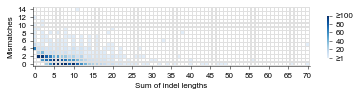

In [33]:
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(linewidth/1, linewidth/4))

hm = sns.heatmap(cluster_matrix[:cl_lim+1].T,cmap="Blues",
        xticklabels = 5, yticklabels = 2,
                mask=cluster_matrix[:cl_lim+1].T==0,
                vmin=0, vmax=100,
                square=True,
                ax=ax,
                center=45,
                linewidths=0.2,
                linecolor="#e0e0e0",
                cbar_kws={"shrink": .5,
                          "ticks": None})
hm.invert_yaxis()
hm.set_xlabel("Sum of indel lengths")
hm.set_ylabel("Mismatches")
hm.set_xlim(0,cl_lim+1)
hm.set_ylim(0,cl_lim_snps+1)

hm_ytick_labs = [0, 2, 4, 6, 8, 10, 12, 14]

ax.set_yticklabels(hm_ytick_labs,
                 rotation = 0)
ax.set_xticklabels(np.arange(0,72,5), rotation = 0)
cbar = ax.collections[0].colorbar
cbar.ax.locator_params(nbins=5)


cbar.ax.set_yticklabels(["≥1",20,40,60,80,"≥100"])


cbar.ax.tick_params(bottom=True,
                axis="both",
                length=3,
                which="major",
                width=border_width)

sns.despine(left=False)

ax.tick_params(bottom=True, left=True,
                    axis="both",
                    length=3,
                    which="major",
                    width=border_width)

# plt.savefig("snps_indels_per_event_heatmap.pdf",
#         format="pdf",
#         bbox_inches="tight")

In [34]:
def determine_point_ordering(swp):
    points = [1,2,3,4]
    return "".join([str(x) for _,x in sorted(zip([int(i) for i in swp],points))])

rearrangement_type_dic = {
    "1432":"①-④-③-②,\n③-②-①-④",
    "3214":"①-④-③-②,\n③-②-①-④",
    "3124":"③-①-②-④,\n①-③-④-②",
    "1342":"③-①-②-④,\n①-③-④-②",
    "3241":"③-②-④-①,\n④-①-③-②",
    "4132":"③-②-④-①,\n④-①-③-②",
    "1324":"①-③-②-④",
    "3142":"③-①-④-②",
    "3412":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "3421":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "4312":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "4321":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
}

all_tsa_output = pd.read_csv("data/1k_30x_haplotypes/final_all_sample_TSA_output.csv",
                             names=df_headers,
                             header=None,
                             index_col=None)

point_orders = []
grouped_point_orders = []
for row in all_tsa_output.iterrows():
    row = row[1]
    p = [row["sp1_ref"],row["sp2_ref"],row["sp3_ref"],row["sp4_ref"]]
    p_order = determine_point_ordering(p)
    point_orders.append(p_order)
    try:
        grouped_point_orders.append(rearrangement_type_dic[p_order])
    except:
        print(p_order, list(row))
all_tsa_output["point_orders"] = point_orders
all_tsa_output["grouped_point_orders"] = grouped_point_orders

all_tsa_output["length_23"] = list((all_tsa_output["sp2_ref"] - all_tsa_output["sp3_ref"]) + 1)
all_tsa_output["distance_14"] = list((all_tsa_output["sp4_ref"] - all_tsa_output["sp1_ref"]))

In [44]:
def determine_point_ordering(swp):
    points = [1,2,3,4]
    return "".join([str(x) for _,x in sorted(zip([int(i) for i in swp],points))])

df_headers_csv = """pop_id,sample_event_id,clus_start_chrom,clus_start_align,clust_start1,
clust_end1,sp1_qry,sp1_ref,sp2_ref,sp3_ref,sp4_ref,iden_up,ident_rep,
ident_down,ident_inv,ident_fwd,ident_epo,masked,sum_ins,sum_del,sum_mis,
sum_nuc,CpG,clus_ins,clus_del,clus_mis,fwd_score,ts_score,ts_score_maxj,ts_ref_seq_len,
ts_qry_seq_len,f1_len,f2_len,f3_len,LPR,chrom""".strip().replace("\n", "").split(",")

rearrangement_type_dic = {
    "1432":"①-④-③-②,\n③-②-①-④",
    "3214":"①-④-③-②,\n③-②-①-④",
    "3124":"③-①-②-④,\n①-③-④-②",
    "1342":"③-①-②-④,\n①-③-④-②",
    "3241":"③-②-④-①,\n④-①-③-②",
    "4132":"③-②-④-①,\n④-①-③-②",
    "1324":"①-③-②-④",
    "3142":"③-①-④-②",
    "3412":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "3421":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "4312":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
    "4321":"③-④-①-②,\n③-④-②-①,\n④-③-①-②,\n④-③-②-①",
}

all_tsa_output = pd.read_csv("data/1k_30x_haplotypes/final_population_template_switches.csv",
                             names=df_headers_csv,
                             header=None,
                             index_col=None)

point_orders = []
grouped_point_orders = []
for row in all_tsa_output.iterrows():
    row = row[1]
    p = [row["sp1_ref"],row["sp2_ref"],row["sp3_ref"],row["sp4_ref"]]
    p_order = determine_point_ordering(p)
    point_orders.append(p_order)
    try:
        grouped_point_orders.append(rearrangement_type_dic[p_order])
    except:
        print(p_order, list(row))
all_tsa_output["point_orders"] = point_orders
all_tsa_output["grouped_point_orders"] = grouped_point_orders

all_tsa_output["length_23"] = list((all_tsa_output["sp2_ref"] - all_tsa_output["sp3_ref"]) + 1)
all_tsa_output["distance_14"] = list((all_tsa_output["sp4_ref"] - all_tsa_output["sp1_ref"]))

In [42]:
# df_headers_csv = """pop_id,sample_event_id,clus_start_chrom,clus_start_align,clust_start1,
# clust_end1,sp1_qry,sp1_ref,sp2_ref,sp3_ref,sp4_ref,iden_up,ident_rep,
# ident_down,ident_inv,ident_fwd,ident_epo,masked,sum_ins,sum_del,sum_mis,
# sum_nuc,CpG,clus_ins,clus_del,clus_mis,fwd_score,ts_score,ts_score_maxj,ts_ref_seq_len,
# ts_qry_seq_len,f1_len,f2_len,f3_len,LPR,chrom""".strip().replace("\n", "").split(",")

# all_tsa_output = pd.read_csv("data/1k_30x_haplotypes/final_population_template_switches.csv",
#                              names=df_headers_csv,
#                              header=None,
#                              index_col=None)

In [ ]:
# widths = [2, 3, 1.5]
# heights = [1, 3, 2]
# spec5 = fig5.add_gridspec(ncols=3, nrows=3, width_ratios=widths,
#                           height_ratios=heights)

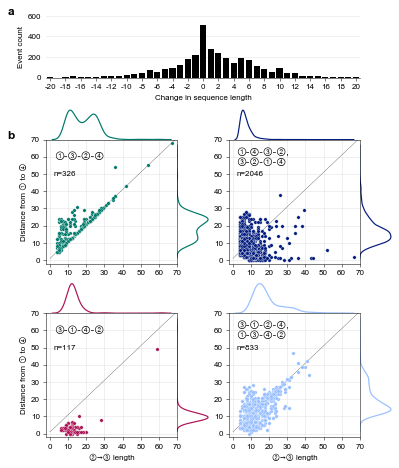

In [46]:
def circled(x):
    return chr(0x245F+x)

fpath= "/System/Library/Fonts/Supplemental/Arial Unicode.ttf"
prop = matplotlib.font_manager.FontProperties(fname=fpath)

colour_dic = {
    '①-④-③-②,\n③-②-①-④':"#051e7f",
    '①-③-②-④':"#00796b",
    '③-①-②-④,\n①-③-④-②':"#97bfff",
    '③-①-④-②':"#ad1457"
}

cus_pal = ["#051e7f","#97bfff","#795548","#8a8a8a","#ad1457","#00796b"]

fig = plt.figure(constrained_layout=False, figsize=(linewidth, linewidth*1.25))
gs = fig.add_gridspec(ncols=5, nrows=9,
                      width_ratios=[2,.5,.3,2,.5],
                      height_ratios=[1,.1,.4,.5,1,1,.3,.5,2])

kde_23_axes = [
    fig.add_subplot(gs[3,0]),
    fig.add_subplot(gs[7,0]),
    fig.add_subplot(gs[3,3]),
    fig.add_subplot(gs[7,3])
]

kde_14_axes = [
    fig.add_subplot(gs[4:6,1]),
    fig.add_subplot(gs[8,1]),
    fig.add_subplot(gs[4:6,4]),
    fig.add_subplot(gs[8,4])
]

scatter_axes = [
    fig.add_subplot(gs[4:6,0]),
    fig.add_subplot(gs[8,0]),
    fig.add_subplot(gs[4:6,3]),
    fig.add_subplot(gs[8,3])
]

length_axes = [
    fig.add_subplot(gs[0,0:4])
]

axis_count = 0
for group in list(set(all_tsa_output["grouped_point_orders"])):
    col = colour_dic[group]
    sub_df = all_tsa_output[all_tsa_output["grouped_point_orders"] == group] 

    scatter_axes[axis_count].plot([0,70],[1,71], 'k-', color="black", linewidth=.25, zorder=1)

    sns.scatterplot(x="length_23",
                    y="distance_14",
                    data=sub_df,
                    ax=scatter_axes[axis_count],
                    color=col,
                    s=12,
                    zorder=2
                    )

    sns.kdeplot(x="length_23",
                data=sub_df,
                ax=kde_23_axes[axis_count],
                color=col)
    sns.kdeplot(y="distance_14",
                data=sub_df,
                ax=kde_14_axes[axis_count],
                color=col)

    scatter_axes[axis_count].text(
        2,
        60,
        group,
        font=prop,
        verticalalignment='center',
        fontsize=10
    )

    scatter_axes[axis_count].text(
        2,
        50,
        "n=" + str(len(sub_df)),
        font=prop,
        verticalalignment='center',
        fontsize=8
    )

    kde_23_axes[axis_count].set_ylabel("")
    kde_23_axes[axis_count].set_xlabel("")

    kde_14_axes[axis_count].set_ylabel("")
    kde_14_axes[axis_count].set_xlabel("")

    kde_14_axes[axis_count].get_xaxis().set_visible(False)
    kde_14_axes[axis_count].get_yaxis().set_visible(False)
    kde_23_axes[axis_count].get_xaxis().set_visible(False)
    kde_23_axes[axis_count].get_yaxis().set_visible(False)

    scatter_axes[axis_count].set_xlim(-2, 70)
    scatter_axes[axis_count].set_ylim(-2, 70)
    
    kde_23_axes[axis_count].axis("off")
    kde_14_axes[axis_count].axis("off")

    scatter_axes[axis_count].set_xticks(np.arange(0,71, 10))
    scatter_axes[axis_count].set_yticks(np.arange(0,71, 10))

    xtick_labs = "" * len(np.arange(0,71, 10))
    ytick_labs = "" * len(np.arange(0,71, 10))

    if axis_count == 0:
        scatter_axes[axis_count].set_xlabel("")
        scatter_axes[axis_count].set_ylabel('Distance from {} to {}'.format(circled(1), circled(4)),font=prop)

        scatter_axes[axis_count].tick_params(
            bottom=True, left=True,
            axis="both",
            length=3,
            which="major",
            width=border_width
        )

    if axis_count == 1:
        scatter_axes[axis_count].set_ylabel('Distance from {} to {}'.format(circled(1), circled(4)),font=prop)
        scatter_axes[axis_count].set_xlabel('{}→{} length'.format(circled(2), circled(3)),font=prop)

        scatter_axes[axis_count].tick_params(
            bottom=True, left=True,
            axis="both",
            length=3,
            which="major",
            width=border_width)


    if axis_count == 2:
        scatter_axes[axis_count].set_xlabel("")
        scatter_axes[axis_count].set_ylabel("")

        scatter_axes[axis_count].tick_params(
            bottom=True, left=True,
            axis="both",
            length=3,
            which="major",
            width=border_width
        )

    if axis_count == 3:
        scatter_axes[axis_count].set_xlabel('{}→{} length'.format(circled(2), circled(3)),font=prop)
        scatter_axes[axis_count].set_ylabel("")

        scatter_axes[axis_count].tick_params(
            bottom=True, left=True,
            axis="both",
            length=3,
            which="major",
            width=border_width
        )

    
    scatter_axes[axis_count].xaxis.grid(
        color="#e0e0e0",
        linewidth=border_width
    )

    scatter_axes[axis_count].yaxis.grid(
        color="#e0e0e0",
        linewidth=border_width
    )

    scatter_axes[axis_count].set_axisbelow(True)
    axis_count += 1

ax = length_axes[0]

len_vals, len_counts = [], []
length_changes = list(all_tsa_output["length_23"] - all_tsa_output["distance_14"]+1)
for i in range(-21, 20):
    len_vals.append(i+1)
    len_counts.append(length_changes.count(i+1))

g = sns.barplot(x=len_vals,
                y=len_counts,
                ax=ax,
                color="black")

xlabs = np.arange(-20,22,2)

ax.set(xticks=xlabs+20, xticklabels=xlabs)

ax.set_ylim([0,602])
ax.set_yticks([0,200,400,600])

ax.set_ylabel("Event count")
ax.set_xlabel("Change in sequence length")

ax.yaxis.grid(
        color="#e0e0e0",
        linewidth=border_width
)

ax.tick_params(bottom=True, left=False,
                    axis="both",
                    length=3,
                    which="major",
                    width=border_width)
ax.tick_params(axis='y', which='major', pad=2)

fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)


ax.text(-0.125, 1.01,
       "a",
       transform=ax.transAxes, 
       size=12, weight='bold')

for spine_i, spine in ax.spines.items():
    if spine_i in ["top", "right", "left"]:
        spine.set_visible(False)


scatter_axes[0].text(-0.3, 1.01,
       "b",
       transform=scatter_axes[0].transAxes, 
       size=12, weight='bold')

ax.set_axisbelow(True)

# plt.savefig(fname="change_in_sequence_length_subplots.pdf",
#             format="pdf",
#             bbox_inches="tight")

In [107]:
intra = "orange"
inter = "darkgreen"

barcolors = {"3-2-4-1":inter,
        "1-4-3-2": inter,
        "3-2-1-4": intra,
        "4-1-3-2": inter,
        "3-1-2-4": inter,
        "1-3-4-2": inter,
        "3-4-2-1": intra,
        "3-1-4-2": inter,
        "1-3-2-4": inter,
        "4-3-1-2": inter,
        "4-3-2-1": intra,
        "3-4-1-2": inter}

color_vector = []
for i in sorted_keys[::-1]:
    color_vector.append(barcolors[i])

In [12]:
coal_val = 0
coal_list = []
for i in range(3202):
    coal_val += 1/(i+1)
    coal_list.append(2*coal_val)
coal_norm = [(float(i)/max(coal_list))*100 for i in coal_list]

In [51]:
events_per_sample, population_list = [], []

for pop in ["AFR", "AMR", "EUR", "SAS", "EAS", "ALL"]:
    with open("data/new_events_per_sample/{}_shuffled_new_events_per_sample.txt".format(pop), "r") as f:
        vals = [int(line.strip()) for line in f.readlines()]
        pops = [pop] * len(vals)
        events_per_sample += vals
        population_list += pops

event_dic = {"event_count": events_per_sample,
             "pop": population_list}

events_per_sample_df = pd.DataFrame.from_dict(event_dic)

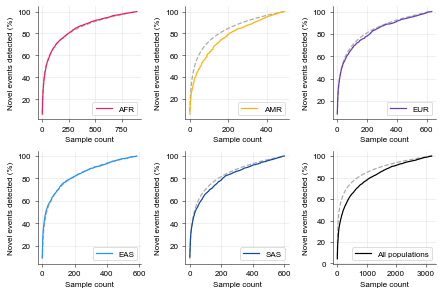

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(linewidth, linewidth/1.5))

axis_lookup = {
    "AFR": ax[0][0],
    "AMR": ax[0][1],
    "EUR": ax[0][2],
    "EAS": ax[1][0],
    "SAS": ax[1][1],
    "ALL": ax[1][2]
}

for pop in ["AFR", "AMR", "EUR", "SAS", "EAS", "ALL"]:
    color = pop_colours[pop]

    curr_ax = axis_lookup[pop]
    sub_df = events_per_sample_df[events_per_sample_df["pop"] == pop]
    coal_val = 0
    coal_list = []

    if pop == "ALL":
        pop_lab = "All populations"
    else:
        pop_lab = pop
    for i in range(2,len(sub_df)+2):
        coal_val += watterson_estimator*(1/i)
        #coal_val += 1/i
        coal_list.append(2*coal_val)
    #coal_norm = coal_list
    coal_norm = [(float(i)/max(coal_list))*100 for i in coal_list]

    y_vals = divide_by_total(list(sub_df["event_count"]))

    arange_len = np.arange(0, len(sub_df["event_count"]))
    sns.lineplot(x=arange_len, y=coal_norm,
                linestyle="dashed",
                color="darkgrey",
                ax=curr_ax)
    sns.lineplot(x=arange_len, y=y_vals, 
                label=pop_lab, color=color,
                ax=curr_ax)

    curr_ax.legend(loc="lower right")
    a = curr_ax
    a.yaxis.grid(color="#e0e0e0",
                 linewidth=border_width)
    a.xaxis.grid(color="#e0e0e0",
                 linewidth=border_width)
    sns.despine(ax=curr_ax)
    a.tick_params(bottom=True, left=True,
                  axis="both",
                  length=3,
                  width=border_width)
    curr_ax.set_xlabel("Sample count")
    curr_ax.set_ylabel("Novel events detected (%)")

fig.tight_layout()

# plt.savefig("new_events_per_sample_vs_coalescent_watt.pdf",
#             format="pdf",
#             facecolor="white",
#             bbox_inches="tight")